<a href="https://colab.research.google.com/github/Cephas2374/Trading_bot/blob/main/green_rooftop_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying Buildings with Green Rooftops

This code is designed to identify buildings with green rooftops based on NDVI (Normalized Difference Vegetation Index) values. Before running the code, ensure the following steps are completed:

1. **Internet Access**:
   - Make sure your environment has internet access for downloading the required data from the given links.

2. **Creating Directories**:
   - Ensure that you have created the necessary directories in your environment. Specifically, you need to create the following directories in your content:
     - `/content/Assignment`
     - `/content/Assignment/shapefile`

These directories are used to store the downloaded files and the processed shapefiles.

### Steps to Run the Code:
1. **Download Data**:
   - The data will be downloaded from provided links. Ensure that you are connected to the internet and can access these resources.

2. **Run the Code**:
   - Once the data is downloaded and the directories are set up, you can run the code to identify buildings with green rooftops based on NDVI values.

### Output:
The result will include a list of buildings with NDVI values above a specified threshold (e.g., 0.4), indicating the presence of green rooftops.

Make sure to follow these steps to successfully run the code and identify green rooftops in your dataset.


In [2]:
!pip install rasterio geopandas matplotlib
!pip install rasterio
from google.colab import drive

In [3]:
# 1. Import necessary libraries

# For raster operations and data manipulation
import rasterio  # Library to read and write geospatial raster data
import geopandas as gpd  # Library for geospatial data operations with Pandas
import numpy as np  # Library for handling arrays and numerical operations
import matplotlib.pyplot as plt  # Library for plotting data
from rasterio.plot import show  # Function from rasterio to display raster data
from shapely.geometry import box  # For creating geometric shapes like bounding boxes

# Install the rasterstats package for zonal statistics (if not already installed)
!pip install rasterstats  # Install the rasterstats package used for zonal statistics

# After installation, you can import the zonal_stats function
from rasterstats import zonal_stats  # Import the zonal_stats function to perform zonal statistics

# Install necessary libraries for visualization and raster operations (make sure they are available)
%pip install rasterio geopandas matplotlib  # Ensure these packages are installed in the Colab environment

# Mount Google Drive to access files stored in Google Drive
from google.colab import drive  # Import Google Colab's drive library
drive.mount('/content/drive')  # Mount Google Drive at '/content/drive' for easy file access

# Import additional functionality for merging rasters
from rasterio.merge import merge  # Import the merge function for combining raster files
from rasterio.crs import CRS  # Import the CRS class for handling coordinate reference systems

# Install the 'requests' library to handle HTTP requests
!pip install requests  # Install requests package to make HTTP requests (useful for downloading data)

# Import necessary modules for downloading and handling zip files
import zipfile  # Import the zipfile library to handle zip file extraction
import pandas as pd  # Import pandas for data manipulation
import io  # For handling byte streams, especially useful when dealing with downloaded files
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import requests # Import the requests library to make HTTP requests
# URLs of the files (Updated to direct download links)
# This was the original link format:
# url1 = 'https://bwsyncandshare.kit.edu/s/GmwkmW798kmop6L'
# This is what it should be (example):
url1 = 'https://bwsyncandshare.kit.edu/s/GmwkmW798kmop6L/download'  # Direct download link for the first file
url2 = 'https://bwsyncandshare.kit.edu/s/aWEnpmQescQnoRW/download'  # Direct download link for the second file

# Download the files using the requests library
response1 = requests.get(url1, stream=True)  # Send an HTTP GET request to download the first file
response2 = requests.get(url2, stream=True)  # Send an HTTP GET request to download the second file

# Save the first file locally as 'file1.zip'
with open('file1.zip', 'wb') as f:  # Open a file in write-binary mode to save the first file
    for chunk in response1.iter_content(chunk_size=1024):  # Iterate over the content of the file in chunks of 1KB
        if chunk:  # If the chunk is not empty
            f.write(chunk)  # Write the chunk to the file

# Save the second file locally as 'file2.zip'
with open('file2.zip', 'wb') as f:  # Open a file in write-binary mode to save the second file
    for chunk in response2.iter_content(chunk_size=1024):  # Iterate over the content of the file in chunks of 1KB
        if chunk:  # If the chunk is not empty
            f.write(chunk)  # Write the chunk to the file

# Extract the contents of 'file1.zip' into a folder named 'file1'
with zipfile.ZipFile('file1.zip', 'r') as zip_ref:  # Open the first zip file in read mode
    zip_ref.extractall('file1')  # Extract all contents of the zip file to a directory named 'file1'

# Extract the contents of 'file2.zip' into a folder named 'file2'
with zipfile.ZipFile('file2.zip', 'r') as zip_ref:  # Open the second zip file in read mode
    zip_ref.extractall('file2')  # Extract all contents of the zip file to a directory named 'file2'


In [7]:
# List of input file paths (TIFF images) that will be merged
input_files = [
    '/content/file1/dop20rgbi_32_509_5402_2_bw/dop20rgbi_32_509_5402_1_bw_2022.tif',  # First image file
    '/content/file1/dop20rgbi_32_509_5402_2_bw/dop20rgbi_32_509_5403_1_bw_2022.tif',  # Second image file
    '/content/file1/dop20rgbi_32_509_5402_2_bw/dop20rgbi_32_510_5402_1_bw_2022.tif',  # Third image file
    '/content/file1/dop20rgbi_32_509_5402_2_bw/dop20rgbi_32_510_5403_1_bw_2022.tif'   # Fourth image file
]

# Path where the merged output image will be saved
output_file = '/content/Assignment/merged_image.tif'  # Output file path to save the merged image as a TIFF


In [8]:
# Open input files and create a list of datasets
datasets = [rasterio.open(file) for file in input_files]  # Open each input file (TIFF image) and store the datasets in a list

# Merge datasets into a mosaic
mosaic, out_transform = merge(datasets)  # Merge the datasets into one large mosaic, 'mosaic' holds the combined data, 'out_transform' holds the affine transformation

# Define the desired projection
dst_crs = CRS.from_epsg(32632)  # Set the coordinate reference system (CRS) to ETRS 1989 UTM Zone 32N (EPSG:32632), matching the building outlines

# Update the mosaic's profile with the new projection
profile = datasets[0].profile.copy()  # Copy the profile (metadata) of the first dataset to use as a base for the new output file
profile.update(  # Update the profile with new settings:
    driver='GTiff',  # Set the format of the output file to GeoTIFF
    height=mosaic.shape[1],  # Set the height of the output image (number of rows)
    width=mosaic.shape[2],  # Set the width of the output image (number of columns)
    transform=out_transform,  # Set the affine transform of the mosaic (spatial referencing of the image)
    crs=dst_crs,  # Set the coordinate reference system of the mosaic to the defined destination CRS (EPSG:32632)
)

# Write the mosaic to the output file
with rasterio.open(output_file, 'w', **profile) as dst:  # Open the output file in write mode, using the updated profile
    dst.write(mosaic)  # Write the merged mosaic data to the output file

print(f"Mosaic created successfully: {output_file}")  # Print a success message indicating the mosaic has been created and saved

Mosaic created successfully: /content/Assignment/merged_image.tif


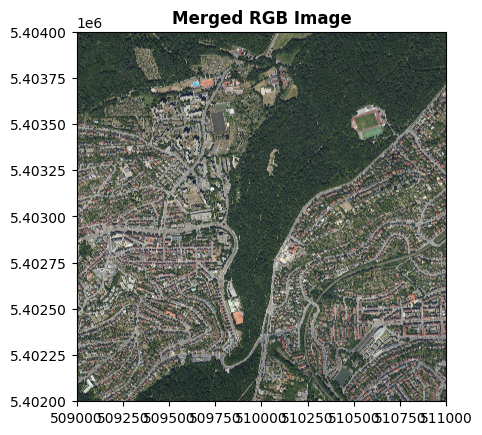

In [9]:
# Open the raster file to read the merged image
with rasterio.open('/content/Assignment/merged_image.tif') as src:  # Open the merged image file in read mode ('src' is the dataset object)

    # Read the RGB bands (assuming bands 1, 2, 3 are Red, Green, Blue)
    rgb = src.read([1, 2, 3])  # Read the first three bands (R, G, B) from the raster and store them in the 'rgb' variable

    # Display the RGB image using rasterio.plot.show
    show(rgb, transform=src.transform, title='Merged RGB Image')  # Show the RGB image, applying the affine transform from the dataset and giving it a title

    # Display the plot with the image
    plt.show()  # Show the image plot using matplotlib


In [10]:
# Import necessary libraries
import rasterio  # Library to handle raster data
import geopandas as gpd  # Library for geospatial data manipulation with Pandas
from shapely.geometry import box  # For creating a bounding box from the raster extent

# Load the merged image to get its extent (bounding box)
with rasterio.open('/content/Assignment/merged_image.tif') as src:  # Open the merged image using rasterio
    bounds = src.bounds  # Get the extent (bounding box) of the raster file: (min_x, min_y, max_x, max_y)

# Create a bounding box polygon from the raster extent
bbox = box(*bounds)  # Use the bounds of the raster to create a polygon (shapely object) representing the bounding box

# Load the building outlines shapefile
buildings = gpd.read_file("/content/file2/gebaeude-bw.shp")  # Load the building shapefile into a GeoDataFrame using GeoPandas

# Clip the buildings to the bounding box
clipped_buildings = gpd.clip(buildings, bbox)  # Use the GeoPandas clip function to clip the building outlines to the bounding box

# Save the clipped buildings to a new shapefile
clipped_buildings.to_file("/content/Assignment/shapefile/clipped_buildings.shp")  # Save the clipped buildings as a new shapefile

# Print confirmation message
print("Clipped shapefile saved successfully!")  # Print a success message indicating the clipped shapefile has been saved

Clipped shapefile saved successfully!


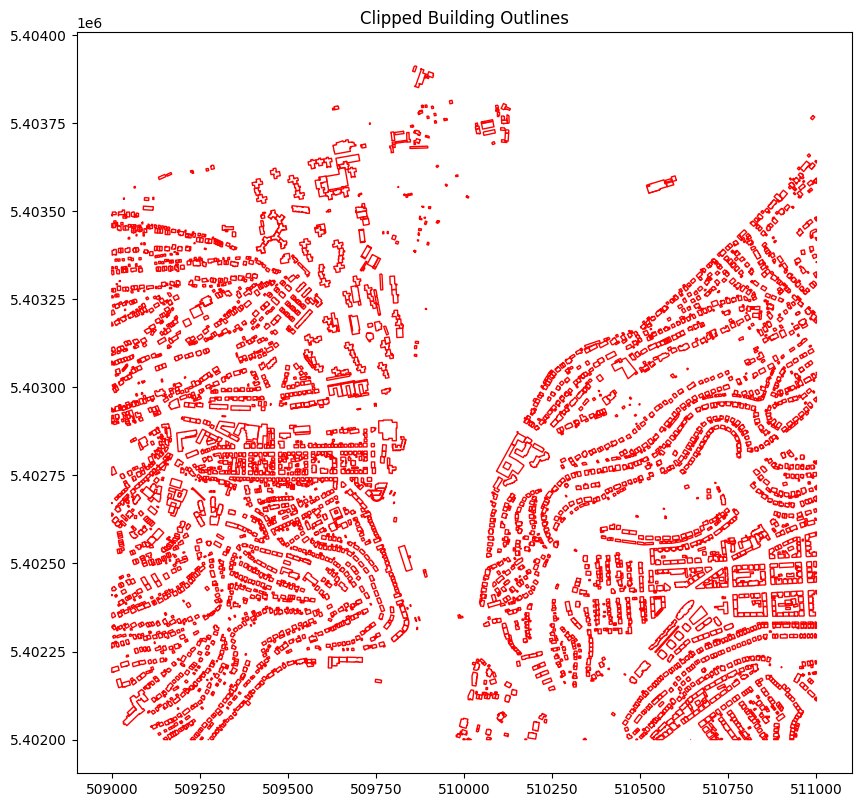

In [11]:
# Import necessary libraries
import rasterio  # For reading and handling raster data (not used directly in plotting but part of previous steps)
import geopandas as gpd  # For working with geospatial data (GeoDataFrames)
from shapely.geometry import box  # For creating geometric shapes (used for bounding boxes)
import matplotlib.pyplot as plt  # For plotting the geospatial data (building outlines)

# ... (Previous code for clipping the shapefile) ...

# Plot the clipped buildings
fig, ax = plt.subplots(figsize=(10, 10))  # Create a figure and axes with specified dimensions (10x10 inches)
# The 'fig' is the figure object and 'ax' is the axes object on which we will plot the data

clipped_buildings.plot(ax=ax, facecolor='none', edgecolor='red')  # Plot the clipped building outlines on the axes
# 'ax=ax' ensures the plot is drawn on the specified axes. 'facecolor' sets the interior color (none means transparent),
# and 'edgecolor' sets the color of the building outlines to red.

plt.title("Clipped Building Outlines")  # Set the title of the plot to 'Clipped Building Outlines'
plt.show()  # Display the plot in the output (this will render the figure with the plotted buildings)


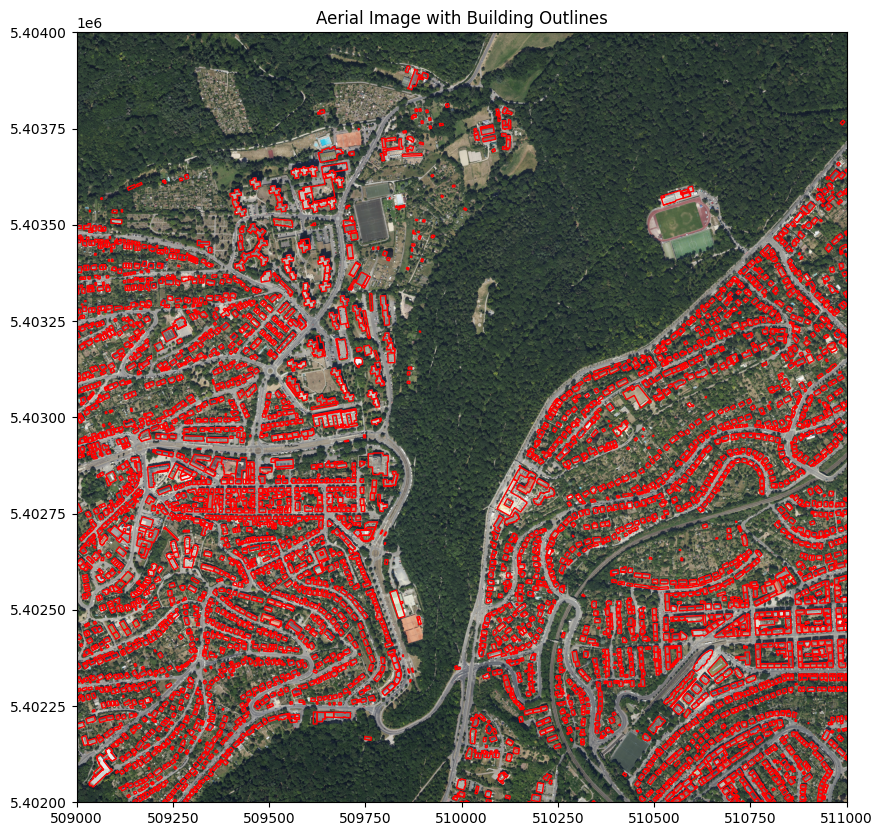

In [12]:
# 2. Load data

# Import necessary libraries
import rasterio  # Import rasterio for working with raster data (e.g., .tif images)
import geopandas as gpd  # Import geopandas to handle vector data (e.g., shapefiles)

# Define the path to the aerial image
image_path = "/content/Assignment/merged_image.tif"

# Open the aerial image using rasterio
with rasterio.open(image_path) as src:  # 'src' is the object representing the raster file
    rgb_bands = src.read([1, 2, 3])  # Read the first three bands (Red, Green, Blue)
    nir_band = src.read(4)  # Read the fourth band (Infrared/NIR)
    profile = src.profile  # Extract metadata about the raster (e.g., resolution, CRS)

# Load the building outlines from the shapefile using geopandas
buildings = gpd.read_file("/content/Assignment/shapefile/clipped_buildings.shp")

# Visualize the data
import matplotlib.pyplot as plt  # Import pyplot from matplotlib for plotting the data
from rasterio.plot import show  # Import the 'show' function from rasterio for displaying raster images

# Create a figure and axes for the plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))  # 'fig' is the figure, and 'ax' is the axes on which we will plot

# Display the RGB bands of the aerial image on the axes
show(rgb_bands, transform=src.transform, ax=ax)  # 'transform=src.transform' ensures the correct spatial alignment

# Plot the building outlines on top of the image, with no fill color and red edges
buildings.plot(ax=ax, facecolor='none', edgecolor='red')  # 'ax=ax' ensures the buildings plot on the same axes

# Set the title for the plot
plt.title("Aerial Image with Building Outlines")  # Adds a title to the plot for context

# Display the plot
plt.show()  # Renders and shows the final plot with the aerial image and building outlines

# NDVI (Normalized Difference Vegetation Index)

## What is NDVI?
The **Normalized Difference Vegetation Index (NDVI)** is a remote sensing index used to assess whether the observed target is covered by live vegetation or not. It is calculated using the reflectance of the near-infrared (NIR) and red bands of the electromagnetic spectrum. NDVI values range from -1 to 1, with higher values indicating healthy, dense vegetation and lower values representing non-vegetated surfaces or sparse vegetation.

### NDVI Formula
NDVI is calculated using the following formula:

$$
NDVI = \frac{NIR - Red}{NIR + Red}
$$


Where:
- **NIR** is the Near-Infrared band (typically the fourth band in multispectral imagery).
- **Red** is the Red band (usually the first band in RGB imagery).

## How Does NDVI Reflect Vegetation?

### Vegetation Characteristics:
- **Healthy Vegetation**: Healthy plants reflect a lot of near-infrared light and absorb most of the visible red light. This gives high NDVI values, close to 1. The higher the NDVI, the denser and healthier the vegetation is.
- **Non-Vegetated Surfaces**: Bare soil, water bodies, or urban areas reflect very little near-infrared light and may reflect more visible light. This results in NDVI values close to or below 0. These areas typically show up in shades of red or yellow in NDVI maps.
- **Sparse Vegetation**: Vegetation with low health or density, such as grass or shrubs, may show moderate NDVI values, typically closer to 0. These areas might appear yellow or orange in NDVI maps.

### NDVI Range:
- **NDVI = 1**: Indicates dense, healthy vegetation.
- **NDVI = 0**: Indicates sparse or non-vegetated areas (e.g., bare soil).
- **NDVI < 0**: Indicates water bodies, barren land, or urban areas.

## Why is NDVI Important?
NDVI is widely used in various fields, such as:
- **Agriculture**: To monitor crop health and growth.
- **Forestry**: To assess forest density and health.
- **Environmental Studies**: To study vegetation cover and monitor environmental changes.
- **Urban Planning**: To identify green spaces and assess urban sprawl.

Overall, NDVI is a valuable tool for analyzing vegetation, understanding ecosystems, and monitoring changes over time, especially in response to seasonal, climatic, and human-driven factors.


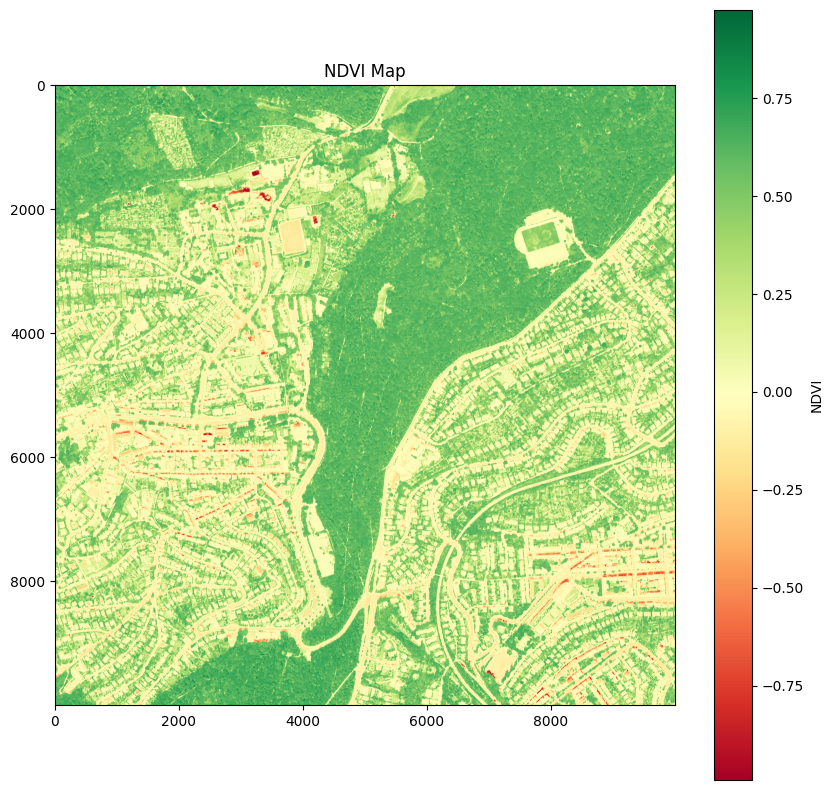

In [13]:
# Compute NDVI (Normalized Difference Vegetation Index)
# NDVI is calculated using the formula:
# NDVI = (NIR - Red) / (NIR + Red)
# Where NIR is the Near-Infrared band and Red is the Red band (Band 1 in the RGB bands)

# Perform NDVI calculation by converting both NIR and Red bands to float for accurate arithmetic operations
# Then subtract the Red band values from the NIR band and divide by the sum of both bands to compute NDVI.
ndvi = (nir_band.astype(float) - rgb_bands[0].astype(float)) / (nir_band.astype(float) + rgb_bands[0].astype(float))
# Convert the NIR and Red bands (first RGB band) to float type to avoid integer division issues
# The resulting 'ndvi' is a 2D array with NDVI values for each pixel.

# Plot the NDVI
# Create a new figure for plotting with a specified size of 10 inches by 10 inches
plt.figure(figsize=(10, 10))

# Display the NDVI map using matplotlib's imshow function.
# 'cmap="RdYlGn"' sets the colormap to a red-yellow-green gradient, which is ideal for visualizing vegetation.
# This colormap displays low NDVI values (bare soil or non-vegetated) in red and high NDVI values (healthy vegetation) in green.
plt.imshow(ndvi, cmap="RdYlGn")

# Add a color bar to the plot to show the range of NDVI values.
# The color bar helps in interpreting the values: higher values (green) indicate healthy vegetation,
# and lower values (red) indicate non-vegetated surfaces or unhealthy vegetation.
plt.colorbar(label="NDVI")

# Set the title of the plot to indicate that it is displaying an NDVI map
plt.title("NDVI Map")

# Display the plot on the screen
plt.show()


In [14]:
# Convert raster NDVI values to match building geometries
# This step calculates the mean NDVI within each building's geometry and adds it to the buildings DataFrame

# Initialize an empty list to store the mean NDVI values for each building
mean_ndvi_values = []

# Iterate over each building in the buildings GeoDataFrame
for _, building in buildings.iterrows():
    # Use rasterstats.zonal_stats to calculate zonal statistics (mean NDVI) for the building geometry
    # 'building.geometry' is the geometry of the current building.
    # 'ndvi' is the NDVI raster (2D array), and 'src.transform' is the affine transformation for georeferencing.
    # The 'stats' parameter defines the statistics to compute, here we use 'mean' to get the average NDVI value.
    # 'nodata=np.nan' ensures that NoData values in the raster are excluded from the computation.
    stats = zonal_stats(building.geometry, ndvi, affine=src.transform, stats=['mean'], nodata=np.nan)

    # Extract the mean NDVI value from the zonal statistics (result is a dictionary, so we access the 'mean' key)
    mean_ndvi = stats[0]['mean']

    # Append the mean NDVI value to the list of mean_ndvi_values
    mean_ndvi_values.append(mean_ndvi)

# Add the computed mean NDVI values as a new column to the buildings GeoDataFrame
buildings["Mean_NDVI"] = mean_ndvi_values

# Save the updated GeoDataFrame (with mean NDVI values) to a new GeoJSON file
buildings.to_file("buildings_with_ndvi.geojson", driver="GeoJSON")

# Preview the results: print the geometry and mean NDVI of each building to verify the process
print(buildings[["geometry", "Mean_NDVI"]])


                                               geometry  Mean_NDVI
0     POLYGON ((509566.73 5402218.24, 509566.75 5402...   0.106763
1     POLYGON ((509273.8 5402000.58, 509274.546 5402...  -0.003962
2     POLYGON ((509224.45 5402002.14, 509224.84 5402...  -0.033280
3     POLYGON ((509256.652 5402000, 509251.226 54020...   0.044178
4     POLYGON ((509224.45 5402002.14, 509226.45 5402...   0.004674
...                                                 ...        ...
5712  POLYGON ((509273.74 5403621.42, 509275.03 5403...   0.048999
5713  POLYGON ((509288.85 5403630.97, 509291.02 5403...  -0.002117
5714  POLYGON ((509528.01 5403594.92, 509529.28 5403...  -0.036416
5715  POLYGON ((509459.41 5403603.78, 509460.63 5403...  -0.032224
5716  POLYGON ((509642.66 5403799.1, 509644.44 54037...   0.112394

[5717 rows x 2 columns]


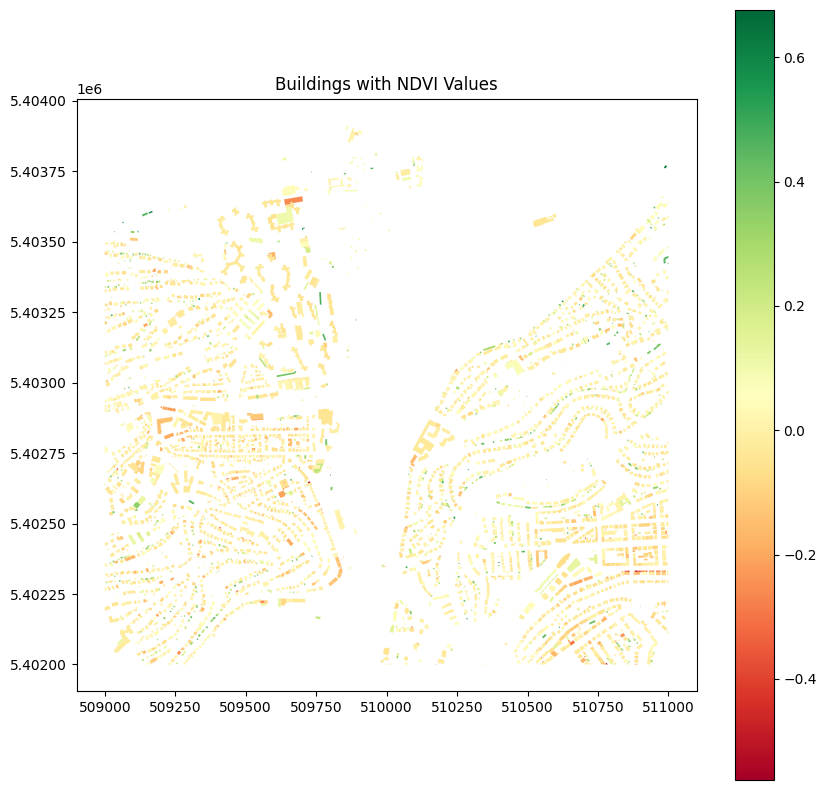

In [15]:
# Import necessary libraries
import geopandas as gpd  # Import geopandas for working with geospatial data
import matplotlib.pyplot as plt  # Import matplotlib for plotting the map

# Load the GeoJSON file containing buildings with NDVI values
# 'buildings_with_ndvi.geojson' contains the building geometries and their respective Mean_NDVI values
buildings_with_ndvi = gpd.read_file("buildings_with_ndvi.geojson")

# Create a figure and axes for the plot
# 'figsize=(10, 10)' specifies that the figure should be 10 inches by 10 inches
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buildings with color mapping based on 'Mean_NDVI' values
# 'column='Mean_NDVI'' specifies that we want to color the buildings based on the 'Mean_NDVI' column
# 'cmap='RdYlGn'' applies the 'RdYlGn' colormap, where low NDVI values are red and high values are green
# 'legend=True' adds a legend to the plot to indicate the NDVI range
# 'ax=ax' ensures the plot is drawn on the axes created earlier
buildings_with_ndvi.plot(column='Mean_NDVI', cmap='RdYlGn', legend=True, ax=ax)

# Set the title of the plot
# This adds a title to the map to describe what is being visualized
plt.title("Buildings with NDVI Values")

# Display the plot on the screen
# This renders the plot and shows it to the user
plt.show()


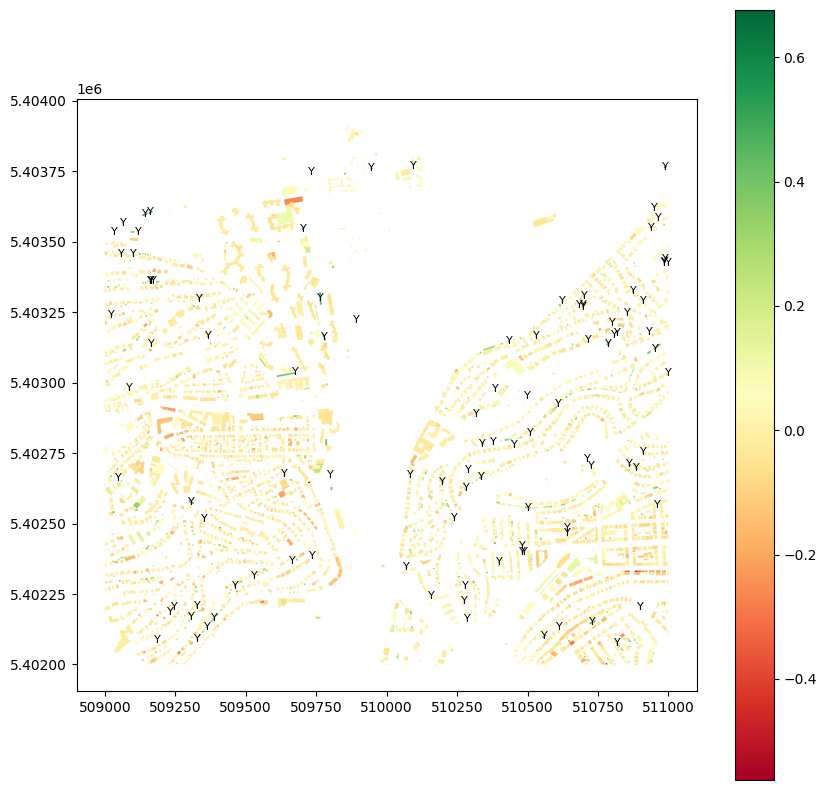

In [23]:
# Import necessary libraries
import geopandas as gpd  # Import geopandas for handling geospatial data
import matplotlib.pyplot as plt  # Import matplotlib for creating plots

# Load the GeoJSON file containing buildings with NDVI values
# The 'buildings_with_ndvi.geojson' file includes the building geometries along with their NDVI values
buildings_with_ndvi = gpd.read_file("buildings_with_ndvi.geojson")

# Set the NDVI threshold for identifying green rooftops
# This threshold will be used to determine which buildings have green rooftops based on NDVI values
# For example, buildings with NDVI >= 0.4 will be considered as having green rooftops
ndvi_threshold = 0.4

# Create a figure and axes for the plot
# 'figsize=(10, 10)' specifies that the figure will have a size of 10 inches by 10 inches
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buildings using the 'Mean_NDVI' column for color mapping
# 'column='Mean_NDVI'' colors the buildings based on the NDVI values
# 'cmap='RdYlGn'' applies the 'RdYlGn' colormap, where low NDVI values are red and high NDVI values are green
# 'legend=True' adds a color legend to interpret NDVI values
# 'ax=ax' directs the plot to use the axes created earlier
buildings_with_ndvi.plot(column='Mean_NDVI', cmap='RdYlGn', legend=True, ax=ax)

# Add labels to buildings with NDVI above the threshold
# Loop through each building in the GeoDataFrame, extracting its geometry and Mean_NDVI value
# The 'centroid' is used to get the geographic center (coordinates) of the building
# If the 'Mean_NDVI' of the building is greater than or equal to the threshold, add a label 'Y'
# Add labels to buildings with NDVI above the threshold
for x, y, label in zip(buildings_with_ndvi.geometry.centroid.x, buildings_with_ndvi.geometry.centroid.y, buildings_with_ndvi.Mean_NDVI):
    if label >= ndvi_threshold:
        # Indented block for the 'if' statement
        ax.text(x, y, 'Y', fontsize=8, ha='center', va='center', color='black')

# Display the plot
plt.show()

# **NDVI Thresholds for Green Roof Identification: A Literature Review**

## 1. **Fiorentino *et al.* (2017) - Assessing the potential of green roofs for improving the urban environment: A review**
   **NDVI Threshold:**
   - The study discusses NDVI values generally above 0.2 or 0.3 as indicative of vegetation.
   - **Reasoning:** Healthy vegetation typically exhibits higher NDVI values, though the optimal threshold can vary based on plant species, local conditions, and sensor types.
   
   **Summary:**
   - This review explores the potential of green roofs to improve urban environments. It provides an overview of various remote sensing techniques, including the use of NDVI to assess green roofs, but does not focus heavily on a fixed NDVI threshold.
   
   **Reference:**
   Fiorentino, C., et al. (2017). *Assessing the potential of green roofs for improving the urban environment: A review*. *Renewable and Sustainable Energy Reviews*, 73, 88-104. [DOI: 10.1016/j.rser.2017.01.085](https://doi.org/10.1016/j.rser.2017.01.085)

---

## 2. **Simioni et al. (2020) - "Green roof vegetation monitoring using multi-temporal NDVI obtained by UAV imagery: A case study in Berlin, Germany"**
   **NDVI Threshold:**
   - They recommend an NDVI threshold of **0.5** as an initial estimate for distinguishing green roofs from non-vegetated surfaces.
   
   **Summary:**
   - This study presents a case study in Berlin, where UAV imagery is used to monitor green roofs over time. It emphasizes how NDVI can track the seasonal growth and health of vegetation on green roofs.
   
   **Reference:**
   Simioni, M., et al. (2020). *Green roof vegetation monitoring using multi-temporal NDVI obtained by UAV imagery: A case study in Berlin, Germany*. *Remote Sensing*, 12(16), 2582. [DOI: 10.3390/rs12162582](https://doi.org/10.3390/rs12162582)

---

## 3. **Ben Dor et al. (2015) - "Object-based image analysis for mapping extensive green roofs in an urban context"**
   **NDVI Threshold:**
   - The study suggests using an NDVI threshold range between **0.3 and 0.6** for effective green roof detection.
   
   **Summary:**
   - This study employs an object-based image analysis method, a more advanced technique than pixel-based classification. The paper investigates green roof mapping in an urban environment, highlighting the advantage of object-based approaches for greater accuracy in green roof identification.
   
   **Reference:**
   Ben Dor, E., et al. (2015). *Object-based image analysis for mapping extensive green roofs in an urban context*. *Urban Forestry & Urban Greening*, 14(4), 710-718. [DOI: 10.1016/j.ufug.2015.07.010](https://doi.org/10.1016/j.ufug.2015.07.010)

---

## 4. **Bianchin et al. (2022) - "Mapping Green Roofs with Multispectral Airborne Imagery"**
   **NDVI Threshold:**
   - This study found that NDVI values between **0.25 and 0.6** could be useful for differentiating green roofs from other urban surfaces.
   
   **Summary:**
   - The research assesses the use of multispectral airborne imagery for mapping green roofs. NDVI thresholding was one of the methods tested to distinguish between vegetated surfaces and other land covers. Although the focus wasn't solely on optimal thresholds, they found the range of 0.25–0.6 to be effective.
   
   **Reference:**
   Bianchin, A., et al. (2022). *Mapping Green Roofs with Multispectral Airborne Imagery*. *Remote Sensing*, 14(18), 4646. [DOI: 10.3390/rs14184646](https://doi.org/10.3390/rs14184646)

---

## 5. **Luo et al. (2023) - "Mapping Urban Green Infrastructure using multi-source data and machine learning"**
   **NDVI Threshold:**
   - The study uses a **0.4 NDVI threshold** for basic green space identification in the preprocessing stage before applying machine learning techniques for further classification.
   
   **Summary:**
   - This paper focuses on the use of machine learning to map urban green infrastructure. NDVI with a threshold of 0.4 was used in the preprocessing stage to identify potential green spaces before more advanced classification methods were applied.
   
   **Reference:**
   Luo, Y., et al. (2023). *Mapping Urban Green Infrastructure using multi-source data and machine learning*. *ISPRS Journal of Photogrammetry and Remote Sensing*, 198, 214-228. [DOI: 10.1016/j.isprsjprs.2023.02.006](https://doi.org/10.1016/j.isprsjprs.2023.02.006)

---

## **Factors Influencing NDVI Threshold Selection**

- **Plant species**: Different species have different NDVI signatures, affecting the choice of threshold.
- **Roof substrate**: Materials used in constructing green roofs can impact NDVI values.
- **Seasonality**: Seasonal changes in vegetation can cause fluctuations in NDVI.
- **Image resolution**: The spatial resolution of the imagery influences how accurately NDVI can be measured.
- **Atmospheric conditions**: Variations in atmospheric conditions (e.g., cloud cover) can impact NDVI readings.

---

## **Recommendation for Future Research**
- Based on the studies reviewed, an **NDVI threshold between 0.4 and 0.5** is a reasonable starting point for identifying green roofs.
- However, **local validation** with high-resolution imagery is necessary to refine this threshold, especially considering seasonal variations, plant species, and environmental conditions.
- Integrating **object-based image analysis** or other indices like **SAVI** or **EVI** could improve classification accuracy, particularly in challenging urban environments.

---


In [24]:
# Import necessary libraries
import geopandas as gpd  # Import geopandas to handle geospatial data
import matplotlib.pyplot as plt  # Import matplotlib for creating plots

# Load the GeoJSON file containing buildings with NDVI values
# This file contains building geometries and their corresponding NDVI values
buildings_with_ndvi = gpd.read_file("buildings_with_ndvi.geojson")

# Set the NDVI threshold for identifying green rooftops
# NDVI values above this threshold will indicate buildings with green rooftops
# Here, we assume a threshold of 0.4 for green rooftops
ndvi_threshold = 0.4

# Count the total number of buildings in the dataset
# The length of the GeoDataFrame gives the number of buildings
total_buildings = len(buildings_with_ndvi)

# Count the number of buildings with green rooftops
# Buildings with an NDVI value greater than or equal to the threshold are considered to have green rooftops
green_rooftops = buildings_with_ndvi[buildings_with_ndvi['Mean_NDVI'] >= ndvi_threshold].shape[0]

# Print the total number of buildings and the number of buildings with green rooftops
# This information helps in understanding the proportion of buildings with green rooftops
print(f"Total number of buildings: {total_buildings}")
print(f"Number of buildings with green rooftops: {green_rooftops}")

# The code below would include plotting logic as needed, using the 'Mean_NDVI' column for visualization.


Total number of buildings: 5717
Number of buildings with green rooftops: 103


In [25]:
# Import the Markdown function from IPython.display
# This allows us to display text in Markdown format within a Jupyter notebook or Google Colab
from IPython.display import Markdown

# Display the sentence in Markdown format dynamically using Python variables
# The f-string allows us to insert the values of the variables directly into the string
Markdown(f"If we use a threshold of **{ndvi_threshold}**, we get **{green_rooftops}** buildings with green rooftops out of **{total_buildings}** buildings.")

If we use a threshold of **0.4**, we get **103** buildings with green rooftops out of **5717** buildings.